In [22]:
#---- Import necessary libraries ----#
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import pandas as pd
from astropy.constants import G, c, M_sun
import astropy.units as u
from scipy.optimize import fsolve

plt.rcParams.update({
    "text.usetex": True,                
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "figure.dpi": 200,                   
    "grid.alpha": 0.4,                    
})


# Quark matter

In [23]:
hc = 197.327 # MeV fm

B = 145 **4 / (hc**3) # MeV/fm^3
B_SI = (B * u.MeV / u.fm**3).to(u.J / u.m**3).value #J/m³
B_geo  = (G.value / c.value**4) * B_SI  # m^-2


n0 = 0.16 # fm^-3

#for massless quarks
m_u = 0.0 # MeV
m_d = 0.0 # MeV
m_s = 0.0 # MeV
m_e = 0.0  # MeV


N_c_quarks = 3
N_c_lep = 1

In [24]:
def number_density_massive(mu, mass):
    # Per s (quark) n = kF^3/pi^2, mu = kF^2 + m^2
    if mu < mass:
        return 0.0
    kF = np.sqrt(mu**2 - mass**2)
    return (kF / hc)**3 / np.pi**2 # MeV/fm^3

def number_density_electron(mu):
    # Electrons: n = kF^3/(3*pi^2), mu = kF
    if mu < 0: return 0
    return (mu / hc)**3 / (3 * np.pi**2) # MeV/fm^3


def pressure_f_massless(N_c, mu_q, m_q):
    factor  = N_c * mu_q**4 / (24 * np.pi**2 * hc**3)
    return factor  # MeV/fm^3

def energy_f_massless(N_c, mu_q, m_q):
    factor  = N_c * mu_q**4 / (8 * np.pi**2 * hc**3)
    return factor # MeV/fm^3



def equationsNB(vars, nB_target):
    mu_u, mu_e= vars
    
    # Beta equilibri
    mu_d = mu_u + mu_e
    mu_s = mu_d 
    
    # Densitats
    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    # 2/3 nu - 1/3 nd - 1/3 ns - ne = 0
    eq_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    # 1/3 (nu + nd + ns) = nB
    eq_baryon = (1/3)*(nu + nd + ns) - nB_target

    return [eq_charge, eq_baryon]
    

In [25]:
# Create EOS table

list_nb_1 = np.linspace(1.7361, 17, 10000) * n0
list_failed_nb_1 = []


list_e_quark = []
list_p_quark = []
guess = [300, 100]  # Initial guess for mu_u and mu_e in MeV

for nB in list_nb_1:
    sol = fsolve(equationsNB, guess, args=(nB))
    mu_u, mu_e = sol    
    mu_d = mu_u + mu_e
    mu_s = mu_d

    nu = number_density_massive(mu_u, m_u)
    nd = number_density_massive(mu_d, m_d)
    ns = number_density_massive(mu_s, m_s)
    ne = number_density_electron(mu_e)

    check_nb = (1/3)*(nu + nd + ns) - nB
    check_charge = (2/3)*nu - (1/3)*nd - (1/3)*ns - ne

    if abs(check_nb) > 1e-6:
        print(f"Warning: nB check failed: {check_nb:.3e} fm^-3")

    if abs(check_charge) > 1e-6:
        print(f"Warning: charge neutrality check failed: {check_charge:.3e} fm^-3")


    pressure_total = (pressure_f_massless(6, mu_u, m_u) + pressure_f_massless(6, mu_d, m_d) +
                    pressure_f_massless(6, mu_s, m_s) + pressure_f_massless(2, mu_e, m_e)) - B

    if pressure_total < 0:
        idx = np.where(list_nb_1 == nB)
        print('Negative pressure reached, stopping at nB=', nB/ n0, idx)
        list_failed_nb_1.append(nB)
        continue


    energy_total =  (energy_f_massless(6, mu_u, m_u) + energy_f_massless(6, mu_d, m_d) +
                    energy_f_massless(6, mu_s, m_s) + energy_f_massless(2, mu_e, m_e)) + B


    list_e_quark.append(energy_total) # MeV/fm^3
    list_p_quark.append(pressure_total) # MeV/fm^3


list_e_quark = np.array(list_e_quark) / (4 * B) #adim
list_p_quark = np.array(list_p_quark) / (4 * B) #adim
print(len(list_failed_nb_1))


minimum_p_quark = np.min(list_p_quark)
minimum_e_quark = np.min(list_e_quark)


maximum_p_quark = np.max(list_p_quark)
maximum_e_quark = np.max(list_e_quark)


print("Minimum pressure quark:", minimum_p_quark * 4 * B)
print()
print("Minimum energy density quark:", minimum_e_quark * 4 * B)
print()
print("Maximum pressure quark:", maximum_p_quark * 4 * B)
print()
print("Maximum energy density quark:", maximum_e_quark * 4 * B)


0
Minimum pressure quark: 0.0037335261175002192

Minimum energy density quark: 230.14078884027293

Maximum pressure quark: 1147.7983369139922

Maximum energy density quark: 3673.524599003896


The EoS table is prepared so its initial value is the closest possible to zero, numerically

# Dark matter

In [26]:
m_f = 100 *1e3 #MeV

M_p = 1.22 * 1e22 #MeV 


a = M_p**3 / m_f**2
b = M_p / m_f**2

hc = 197.3269804 #MeV fm

def p(k_f):

    z = k_f / m_f

    factor = (m_f**4) / (24 * np.pi**2)
    term1 = (2*z**3-3*z)
    term2 = (1+z**2)**0.5
    term3 = 3 * np.arcsinh(z)
    val = factor * (term1*term2 + term3)
    return np.where(z < 1e-6, 0.0, val)

def e(k_f):
    z = k_f / m_f
    factor = (m_f**4) / (8 * np.pi**2)
    term1 = (2*z**3 + z)
    term2 = (1+z**2)**0.5
    term3 = np.arcsinh(z)
    val = factor * (term1*term2 - term3)
    return np.where(z < 1e-6, 0.0, val) #Mev^4

def p_dm_vectorized(k_f):
    z = k_f / m_f
    factor = (m_f**4) / (24 * np.pi**2)
    
    # 1. Full Analytical Formula
    term1 = (2*z**3 - 3*z)
    term2 = np.sqrt(1 + z**2)
    term3 = 3 * np.arcsinh(z)
    val_full = factor * (term1 * term2 + term3)
    
    # 2. Taylor Expansion for small z (Numerical stability)
    # This prevents the '0.0' cliff and helps the solver
    val_tiny = factor * (8/5 * z**5)
    
    # Use the expansion if z is small, otherwise use the full formula
    return np.where(z < 1e-2, val_tiny, val_full)

def e_dm_vectorized(k_f):
    z = k_f / m_f
    factor = (m_f**4) / (8 * np.pi**2)
    
    # Full formula
    val_full = factor * ((2*z**3 + z)*np.sqrt(1+z**2) - np.arcsinh(z))
    
    # Taylor Expansion for energy density: epsilon approx n*m + kinetic
    # For very small z, epsilon is dominated by rest mass:
    val_tiny = factor * (8/3 * z**3) 
    
    return np.where(z < 1e-2, val_tiny, val_full)

max_kf = 1e0
min_kf = 2e-6
number_points = int(1e3)
list_kf = np.linspace(min_kf, max_kf, number_points) * m_f  #MeV

list_p_DM = np.array(p_dm_vectorized(list_kf)) # Physical units (MeV^4) 
list_e_DM = np.array(e_dm_vectorized(list_kf)) # Physical units (MeV^4)


To solved the coupled equations, I need to use the same adimensionalization, otherwhise doesn't have physical sense

In [27]:
list_p_DM = list_p_DM / (hc)**3 #Mev/fm^3
list_e_DM = list_e_DM / (hc)**4 #Mev/fm^3


list_e_DM = np.array(list_e_DM) / (4 * B) #adim
list_p_DM = np.array(list_p_DM) / (4 * B) #adim

#list_p_DM_geo = (G.value / c.value**4) * (np.array(list_p_DM) * u.MeV / u.fm**3).to(u.J / u.m**3).value  # m^-2
#list_e_DM_geo = (G.value / c.value**4) * (np.array(list_e_DM) * u.MeV / u.fm**4).to(u.J / u.m**4).value  # m^-2

#list_p_DM = list_p_DM_geo / (4*B_geo) #adim
#list_e_DM = list_e_DM_geo / (4*B_geo) #adim


In [28]:
# Print minimum value of dm and quark

minimum_p_DM = np.min(list_p_DM)
minimum_e_DM = np.min(list_e_DM)
minimum_p_quark = np.min(list_p_quark)
minimum_e_quark = np.min(list_e_quark)


maximum_p_DM = np.max(list_p_DM)
maximum_e_DM = np.max(list_e_DM)
maximum_p_quark = np.max(list_p_quark)
maximum_e_quark = np.max(list_e_quark)

print("Minimum pressure DM:", minimum_p_DM)
print("Minimum pressure quark:", minimum_p_quark)
print()
print("Minimum energy density DM:", minimum_e_DM)
print("Minimum energy density quark:", minimum_e_quark)
print()
print("Maximum pressure DM:", maximum_p_DM)
print("Maximum pressure quark:", maximum_p_quark)
print()
print("Maximum energy density DM:", maximum_e_DM)
print("Maximum energy density quark:", maximum_e_quark)


print('list_p_quark[700], list_e_quark[700]', list_p_quark[700], list_e_quark[700])


Minimum pressure DM: 1.2224387356452617e-20
Minimum pressure quark: 1.6223581442517215e-05

Minimum energy density DM: 7.743737913888318e-11
Minimum energy density quark: 1.0000486707443277

Maximum pressure DM: 293649648.61760736
Maximum pressure quark: 4.987617392369526

Maximum energy density DM: 12200986.63206929
Maximum energy density quark: 15.962852177108577
list_p_quark[700], list_e_quark[700] 0.2239286196197156 1.6717858588591468


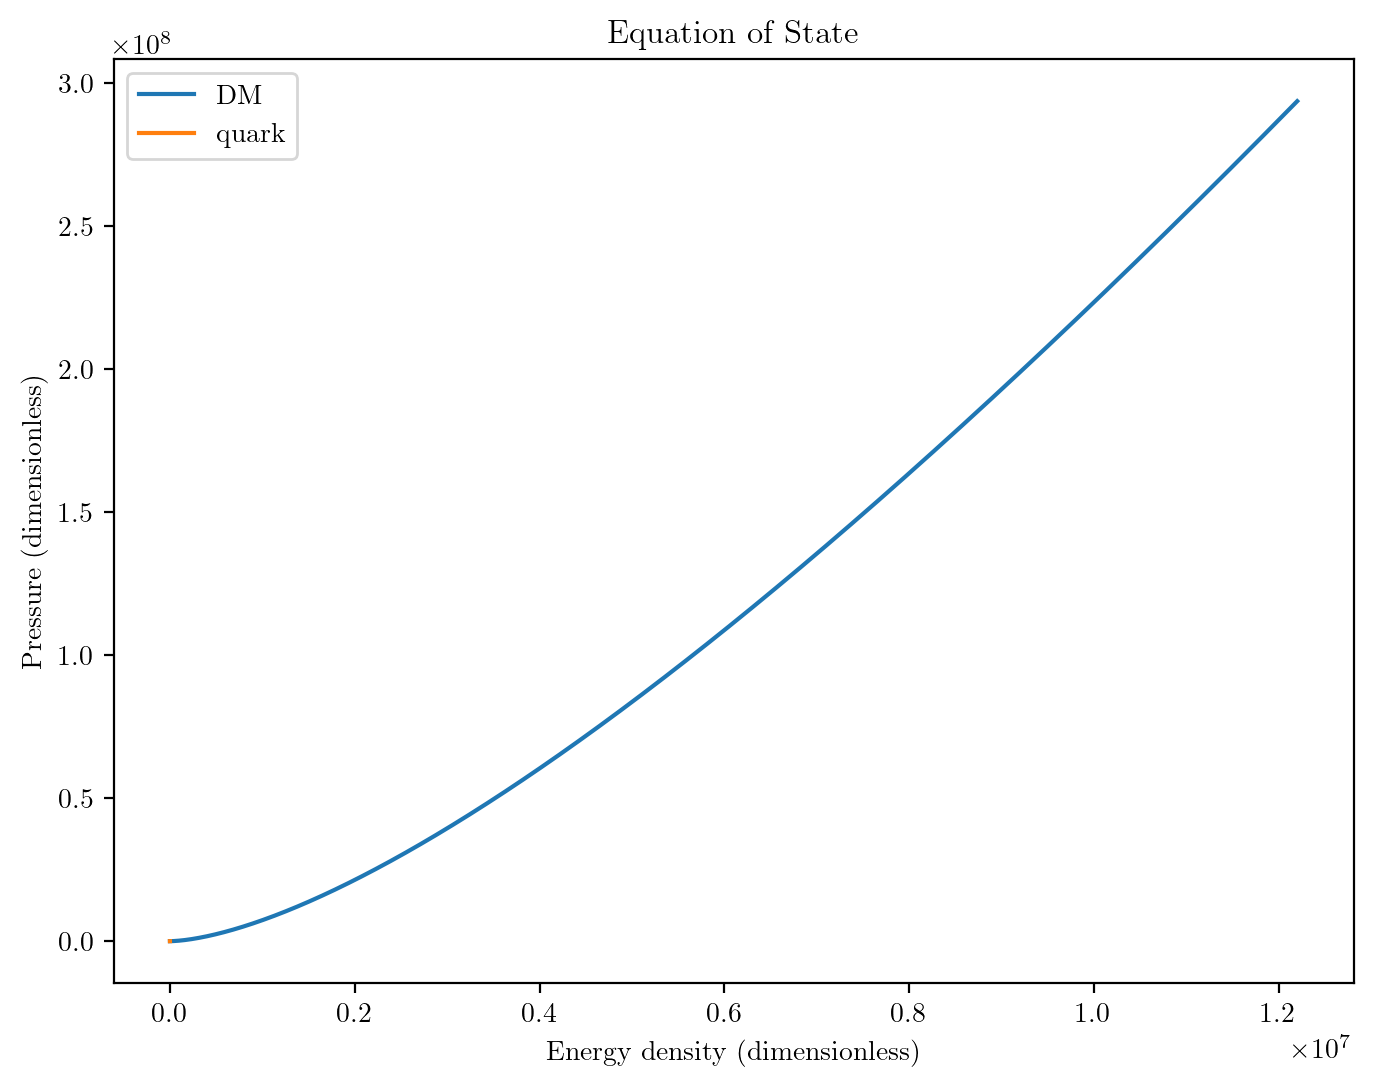

In [29]:
plt.figure(figsize=(8,6))

plt.plot(list_e_DM, list_p_DM, label='DM')
plt.plot(list_e_quark, list_p_quark, label ='quark')
plt.legend()
plt.xlabel('Energy density (dimensionless)')
plt.ylabel('Pressure (dimensionless)')
plt.title('Equation of State')
#plt.xscale('log')
#plt.yscale('log')
plt.show()

#there is clearly a difference in scaling

Two fluid

Central pressure quark: 0.2239286196197156
Central energy density quark: 1.6717858588591468
Central mass quark: 7.002760230089597e-18
Central pressure DM: 13036.133348422676
Central energy density DM: 20385.891481929222
Central mass DM: 8.539222255534344e-14
Final raw quark pressure: -3.6870850617473593e-09
Final raw DM pressure: 1.0000000000242691e-12
Quark surface radius: 0.0011631932755091583
DM surface radius:    None
Final integration radius: 0.005553522991256456


/var/folders/6r/ybm93j_j1ts94x2_43y78jnw0000gn/T/ipykernel_81770/853293077.py:20: RuntimeWarning: divide by zero encountered in scalar divide
  term1 = (1 + p1 / e1)


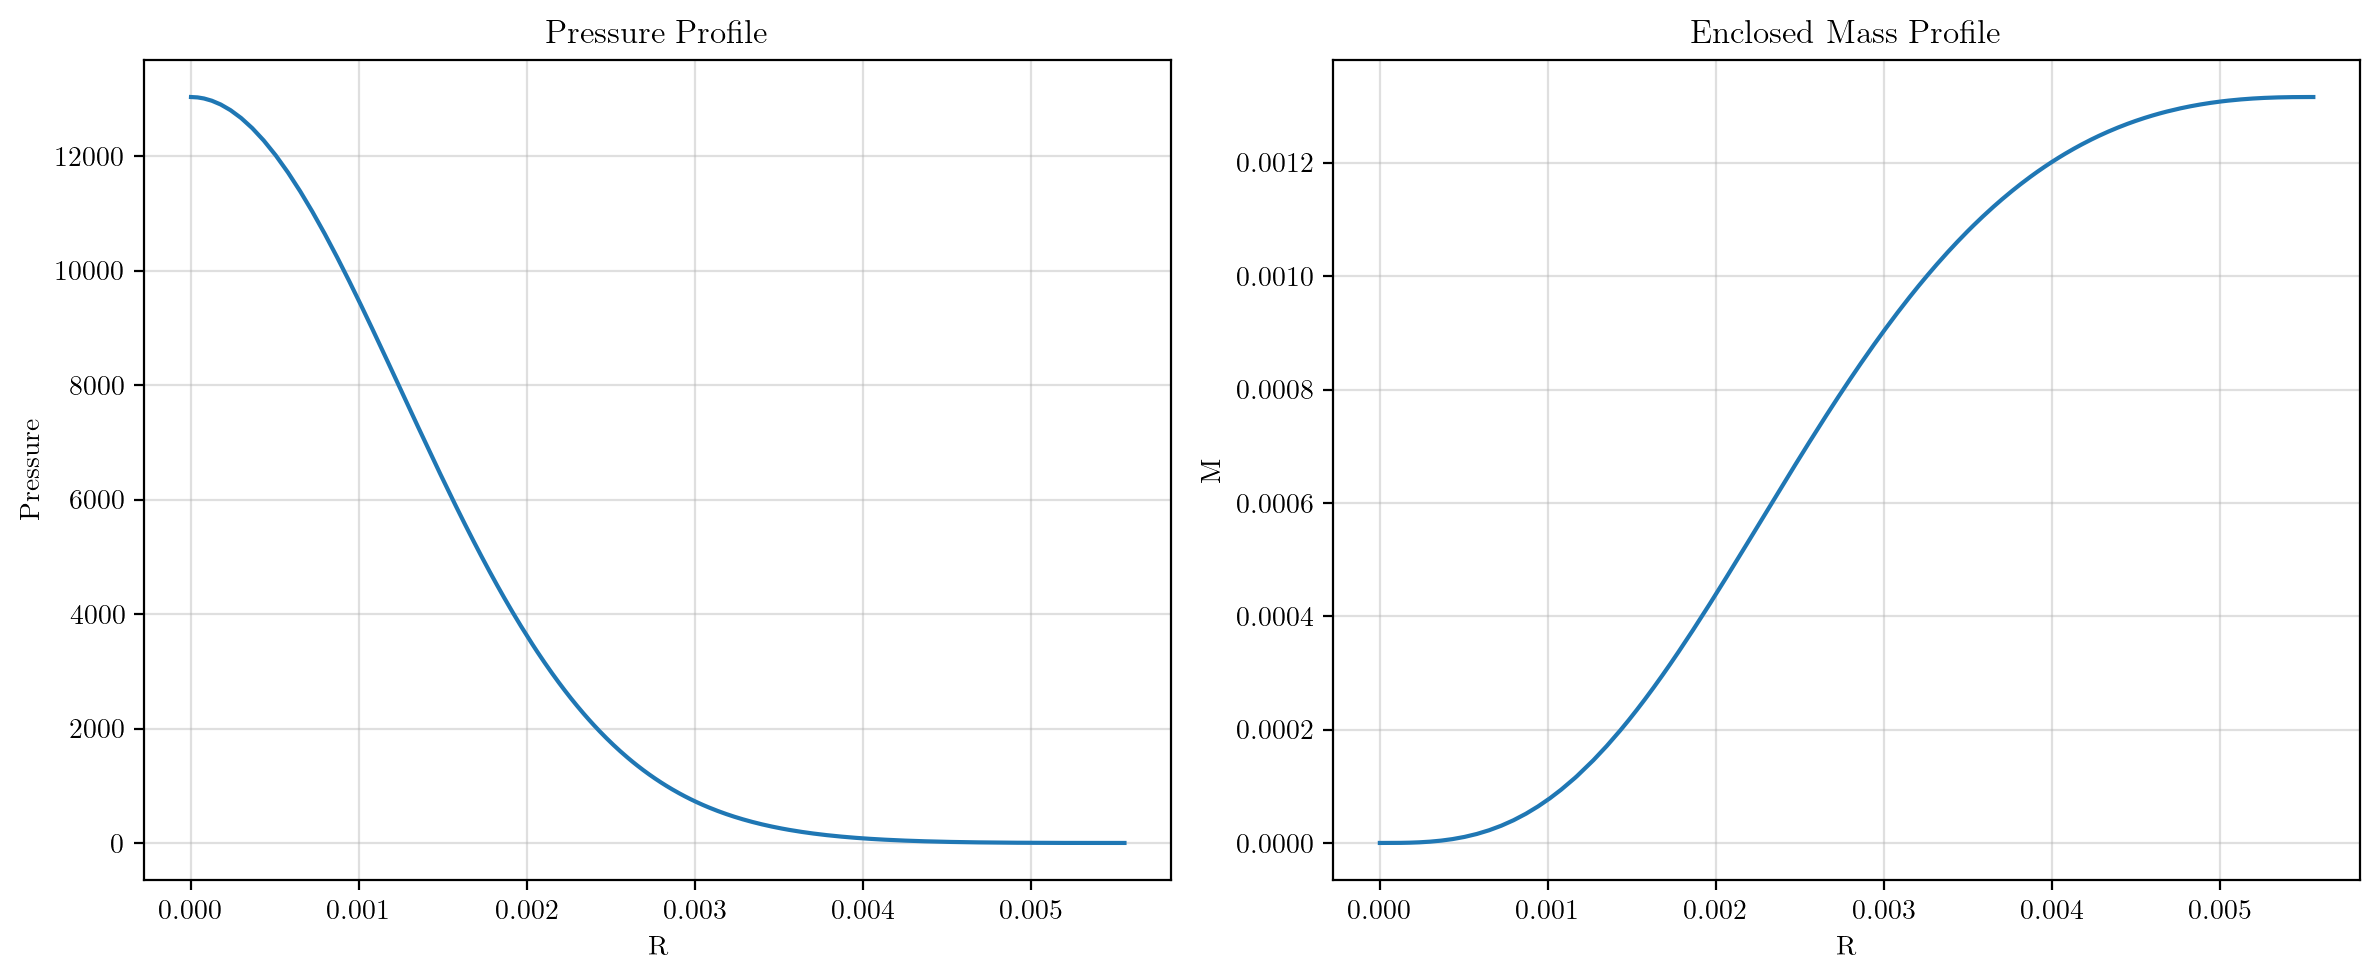

In [30]:
# ----------------------------------------------------
# TOV equations
# ----------------------------------------------------

def ode_TOV(r, x):
    p1, M1, p2, M2 = x

    # 1. Force zero if pressure has already been zero
    #e1 = np.interp(p1, list_p_quark, list_e_quark) 
    #e2 = np.interp(p2, list_p_DM, list_e_DM) if p2 > minimum_p_DM else 0.0
    e1 = np.interp(p1, list_p_quark, list_e_quark) if p1 > 0.0 else 0.0 
    e2 = np.interp(p2, list_p_DM, list_e_DM) if p2 > 0.0 else 0.0
    M = M1 + M2

    # Avoid division by zero at the center
    if r < 1e-10: 
        return [0, 0, 0, 0] 

    factor = - M * e1 / r**2
    term1 = (1 + p1 / e1)
    term2 = (1 + 4 * np.pi * r**3 * (p1 + p2) / M)
    term3 = 1 - 2 * M / r

    if term3 <= 0:
        raise RuntimeError("Horizon reached")

    
    if p1 <= 0.:
        dp1dr = 0.
    else:
        dp1dr = factor * term1 * term2 / term3

    if p2 <= 0.:
        dp2dr = 0.
    else:   
        factor = - M * e2 / r**2
        dp2dr = factor * (1 + p2 / e2) * term2 / term3

    dM1dr = 4 * np.pi * r**2 * e1
    dM2dr = 4 * np.pi * r**2 * e2

    return [dp1dr, dM1dr, dp2dr, dM2dr]



def surface_event(r, x):
    p1, M1, p2, M2 = x
    # We want to stop only when BOTH pressures are zero.
    # Taking the max() means the function only hits 0 
    # when the last remaining fluid reaches its surface.
    return max(p1, p2) - 1e-12 

surface_event.terminal = True 
surface_event.direction = -1



#Initial conditions

r0 = 1e-6
central_pressure_quark = list_p_quark[700] 
central_energy_quark = list_e_quark[700]
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM_physical = 3e6 #mev /fm^3# i want this specific value
#central_pressure_geo = (G.value / c.value**4) * (central_pressure_DM_physical * u.MeV / u.fm**3).to(u.J / u.m**3).value  # m^-2
central_pressure_DM = central_pressure_DM_physical / (4 * B)
central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM

x0 = [central_pressure_quark, central_mass_quark, central_pressure_DM, central_mass_DM]

print("Central pressure quark:", central_pressure_quark)
print("Central energy density quark:", central_energy_quark)
print("Central mass quark:", central_mass_quark)
print("Central pressure DM:", central_pressure_DM)
print("Central energy density DM:", central_energy_DM)
print("Central mass DM:", central_mass_DM)
# ----------------------------------------------------
# Solve ODE
# ----------------------------------------------------
sol = solve_ivp(
    ode_TOV,
    (r0, 1e8),     # integrate up to r=1e10 smaller than one km
    x0,
    events=surface_event, 
    #max_step=0.1,
        rtol=1e-8, atol=1e-10 #tolerance error
)

radius = sol.t
pressure_1 = sol.y[0]
mass_1 = sol.y[1]
pressure_2 = sol.y[2]
mass_2 = sol.y[3]


final_pressure_raw = sol.y[0, -1]
print("Final raw quark pressure:", final_pressure_raw)

final_pressure_raw = sol.y[2, -1]
print("Final raw DM pressure:", final_pressure_raw)


p_tol = 1e-12

idx_q = np.where(pressure_1 <= p_tol)[0]

if len(idx_q) > 0:
    R_quark = radius[idx_q[0]]
else:
    R_quark = None

idx_dm = np.where(pressure_2 <= p_tol)[0]

if len(idx_dm) > 0:
    R_DM = radius[idx_dm[0]]
else:
    R_DM = None


if R_quark is not None and R_DM is not None:
    if R_quark < R_DM:
        print("Quark pressure goes to zero first")
    elif R_DM < R_quark:
        print("DM pressure goes to zero first")
    else:
        print("Both pressures vanish at the same radius")



print(f"Quark surface radius: {R_quark}")
print(f"DM surface radius:    {R_DM}")
print(f"Final integration radius: {radius[-1]}")

# Plot results
# ----------------------------------------------------
plt.figure(figsize=(12,5))

pressure = pressure_1 + pressure_2
mass = mass_1 + mass_2
plt.subplot(1,2,1)
#plt.plot(radius_km, pressure* (m_f**4))
plt.plot(radius, pressure)
plt.xlabel("R")
plt.ylabel("Pressure")
plt.title("Pressure Profile")
plt.grid()

plt.subplot(1,2,2)
#plt.plot(radius_km, mass_in_solar)
plt.plot(radius,mass)
plt.xlabel("R")
plt.ylabel("M")
plt.title("Enclosed Mass Profile")
plt.grid()

plt.tight_layout()
plt.show()


In [31]:


list_r0 = np.logspace(-6, 1, 7)  # from 1e-6 to 10 km
bad_r0 = []
good_r0=[]
for r0 in list_r0:
    central_pressure_quark = list_p_quark[700] #this one i dont care, 700 is an example
    central_energy_quark = list_e_quark[700]
    central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

    central_pressure_DM_physical = 3e6 #mev /fm^3# i want this specific value
    central_pressure_DM = central_pressure_DM_physical / (4 * B)
    central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)
    central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM
    check = 2 * (central_mass_quark + central_mass_DM) / r0
    metric_check = 1 - check

    #print("r0:", r0, "Metric check:", metric_check)
   # print("Central mass quark:", central_mass_quark)
    #print("Central mass DM:", central_mass_DM)

    if metric_check <= 0:
        bad_r0.append(r0)
        print("Bad r0 found:", r0)

    if check < 1e-3:
        good_r0.append(r0)
        print("Good r0 found:", r0)




Good r0 found: 1e-06
Good r0 found: 1.4677992676220705e-05
Bad r0 found: 0.0031622776601683794
Bad r0 found: 0.04641588833612782
Bad r0 found: 0.6812920690579622
Bad r0 found: 10.0


A flat profile means that the iteration started at a radius very small, inside the swarchild radius. Therefore the denominator is negative, pressure gradients are positive. The solver didnt work and is returning the initial values

In [32]:
#convert pressure to a csv
data = {
    'Quark Pressure': pressure_1,
    'DM Pressure': pressure_2,
    'Mass Quark': mass_1,
    'Mass DM': mass_2,
    'Radius': radius
}

df = pd.DataFrame(data)
#df.to_csv('two_fluid_TOV_solution.csv', index=False)


In [33]:

print("Minimum pressure DM:", minimum_p_DM)
print("Minimum pressure quark:", minimum_p_quark)
print()
print("Minimum energy density DM:", minimum_e_DM)
print("Minimum energy density quark:", minimum_e_quark)
print()
print("Maximum pressure DM:", maximum_p_DM)
print("Maximum pressure quark:", maximum_p_quark)
print()
print("Maximum energy density DM:", maximum_e_DM)
print("Maximum energy density quark:", maximum_e_quark)

print()
print('list_p_quark[700], list_e_quark[700]', list_p_quark[700], list_e_quark[700])
print()

#quark matter central pressure
r0 = 1e-6
central_pressure_quark = list_p_quark[700] #this one i dont care, 700 is an example
central_energy_quark = list_e_quark[700]
central_mass_quark = (4/3) * np.pi * r0**3 * central_energy_quark

central_pressure_DM_physical = 3e6 #mev /fm^3# i want this specific value
#central_pressure_geo = (G.value / c.value**4) * (central_pressure_DM_physical * u.MeV / u.fm**3).to(u.J / u.m**3).value  # m^-2
central_pressure_DM = central_pressure_DM_physical / (4 * B)
central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM

print('r0 used for initial conditions:', r0)
print()
print("Central pressure quark:", central_pressure_quark)
print("Central energy density quark:", central_energy_quark)
print("Central mass quark:", central_mass_quark)
print("Central pressure DM:", central_pressure_DM)
print("Central energy density DM:", central_energy_DM)
print("Central mass DM:", central_mass_DM)
print()
check = 2 * (central_mass_quark + central_mass_DM) / r0
print("2M/r0:", check)
print()



Minimum pressure DM: 1.2224387356452617e-20
Minimum pressure quark: 1.6223581442517215e-05

Minimum energy density DM: 7.743737913888318e-11
Minimum energy density quark: 1.0000486707443277

Maximum pressure DM: 293649648.61760736
Maximum pressure quark: 4.987617392369526

Maximum energy density DM: 12200986.63206929
Maximum energy density quark: 15.962852177108577

list_p_quark[700], list_e_quark[700] 0.2239286196197156 1.6717858588591468

r0 used for initial conditions: 1e-06

Central pressure quark: 0.2239286196197156
Central energy density quark: 1.6717858588591468
Central mass quark: 7.002760230089597e-18
Central pressure DM: 13036.133348422676
Central energy density DM: 20385.891481929222
Central mass DM: 8.539222255534344e-14

2M/r0: 1.7079845063114708e-07



In [34]:

def solve_TOV(central_energy, x0):
    def ode_TOV(r, x):
        p1, M1, p2, M2 = x

        e1 = np.interp(p1, list_p_quark, list_e_quark) if p1 > 0.0 else 0.0 
        e2 = np.interp(p2, list_p_DM, list_e_DM) if p2 > 0.0 else 0.0
        M = M1 + M2

        factor = - M * e1 / r**2
        term1 = (1 + p1 / e1)
        term2 = (1 + 4 * np.pi * r**3 * (p1 + p2) / M)
        term3 = 1 - 2 * M / r

        if term3 <= 0:
            raise RuntimeError("Horizon reached")

        if p1 <= 0.:
            dp1dr = 0.
        else:
            dp1dr = factor * term1 * term2 / term3

        if p2 <= 0.:
            dp2dr = 0.
        else:   
            factor = - M * e2 / r**2
            dp2dr = factor * (1 + p2 / e2) * term2 / term3

        dM1dr = 4 * np.pi * r**2 * e1
        dM2dr = 4 * np.pi * r**2 * e2

        return [dp1dr, dM1dr, dp2dr, dM2dr]
    
    # ----------------------------------------------------
    # Solve ODE
    # ----------------------------------------------------

    sol = solve_ivp(
        ode_TOV,
        (r0, 1e8),    
        x0,
        events=surface_event, 
        rtol=1e-8, atol=1e-10 
    )


    radius = sol.t
    pressure_1 = sol.y[0]
    mass_1 = sol.y[1]
    pressure_2 = sol.y[2]
    mass_2 = sol.y[3]

    pressure = pressure_1 + pressure_2
    mass = mass_1 + mass_2

    p_tol = 1e-11

    final_pressure_raw = sol.y[0, -1]
    idx_q = np.where(pressure_1 <= p_tol)[0]

    if len(idx_q) > 0:
        R_quark = radius[idx_q[0]]
    else:
        R_quark = None
        print('Quark pressure not reaching zero', final_pressure_raw)

    final_pressure_raw = sol.y[2, -1]
    idx_dm = np.where(pressure_2 <= p_tol)[0]

    if len(idx_dm) > 0:
        R_DM = radius[idx_dm[0]]
    else:
        R_DM = None
        print('DM pressure not reaching zero', final_pressure_raw)


    if len(sol.t_events[0]) == 0:
        print(f"No surface event for central energy = {central_energy}")
        return np.nan, np.nan
        
    R_surface = sol.t_events[0][0]
    M_surface = mass[-1] #check if this gives the corect mass

    return R_surface, M_surface

def surface_event(r, x):
    p1, M1, p2, M2 = x
    return max(p1, p2) - 1e-12 

surface_event.terminal = True 
surface_event.direction = -1


list_R_1 = []
list_M_1 = []

#Initial conditions for DM are constant

central_pressure_DM_physical = 3e6 #mev /fm^3# i want this specific value
central_pressure_DM = central_pressure_DM_physical / (4 * B)
    
central_energy_DM = np.interp(central_pressure_DM, list_p_DM, list_e_DM)
central_mass_DM = (4/3) * np.pi * r0**3 * central_energy_DM

for i in range(0, len(list_nb_1), 5):
    e, p = list_e_quark[i], list_p_quark[i]
    r0 = 1e-6


    central_mass_quark = (4/3) * np.pi * r0**3 * e

    x0 = [p, central_mass_quark, central_pressure_DM, central_mass_DM]

    R_surface, M_surface = solve_TOV(e, x0)

    list_R_1.append(R_surface)
    list_M_1.append(M_surface)



/var/folders/6r/ybm93j_j1ts94x2_43y78jnw0000gn/T/ipykernel_81770/3638626585.py:10: RuntimeWarning: divide by zero encountered in scalar divide
  term1 = (1 + p1 / e1)


In [35]:
list_e_quark_final = list_e_quark[::5]

/var/folders/6r/ybm93j_j1ts94x2_43y78jnw0000gn/T/ipykernel_81770/2198679041.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


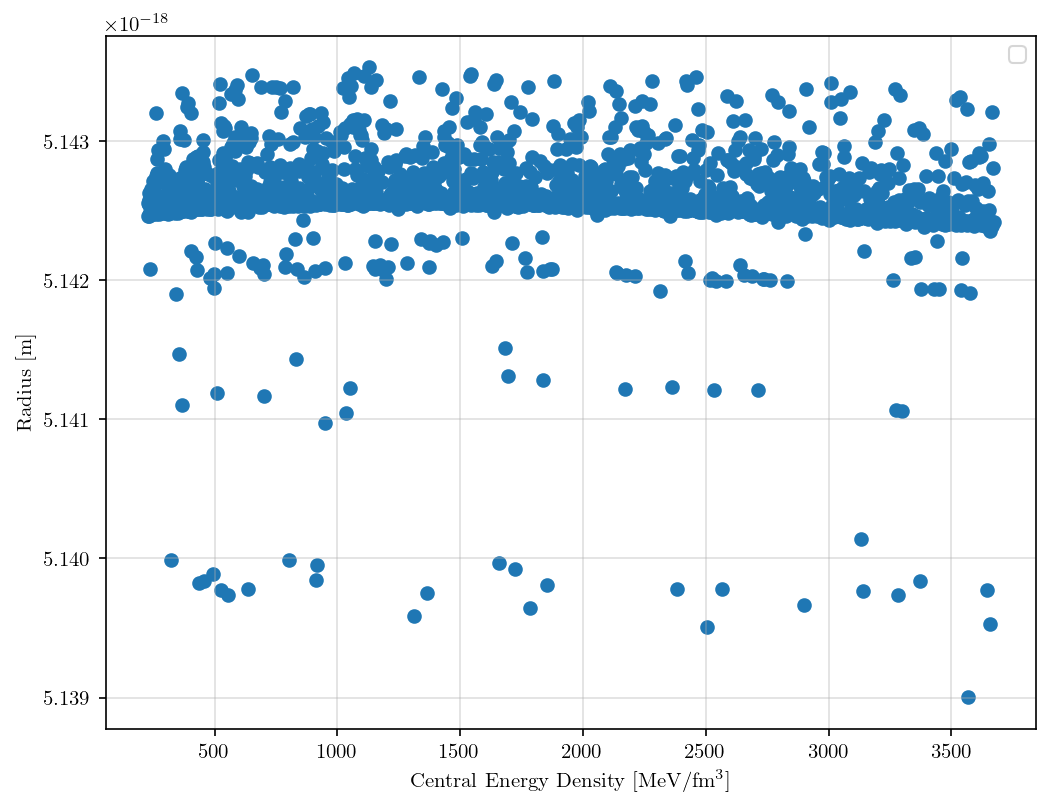

In [36]:
plt.figure(figsize=(8,6), dpi=150)
list_R_1_m = np.array(list_R_1) / (2 * B**0.5) * hc**0.5 *10 **(-15) # m

plt.scatter(list_e_quark_final * 4 * B, list_R_1_m)
plt.xlabel('Central Energy Density [MeV/fm$^3$]')
#plt.ylabel('Mass [MeV]')
plt.ylabel('Radius [m]')
#plt.ylabel('Mass [M$_\odot$]')
plt.grid()

plt.legend()
plt.show()
